In [1]:
import numpy as np
import matplotlib.pyplot as plt

from confusion import ConfusionMatrix
from loader import echo_study
from util import resolve_compensation_value, mean_of_matrices

✅ Loaded 110 entries
🚨 Rejected 144 entries


In [2]:
from functools import reduce

def plot_confusion(conditions, title, label_fields):
    fig, axes = plt.subplots(nrows=1, ncols=len(conditions), figsize=(6 * len(conditions), 6))
    axes_iter = iter(axes)
    fig.suptitle(title, size=20)
    for condition in conditions:
        responses = condition.get_participants_responses()
        label = condition.label(*label_fields)
        mts = [ConfusionMatrix.of_azimuths(p.get_responses()).true_values_sum_to_unity for p in condition.get()]
        mean_confusion = mean_of_matrices(mts)
        axis = next(axes_iter)
        axis.set_title(f"{label} (n={condition.count()})")
        axis.imshow(mean_confusion, extent=[-90, 90, -90, 90])
        axis.set_xlabel("Reported azimuth (degrees)")
        axis.set_ylabel("True azimuth (degrees)")
    plt.show()


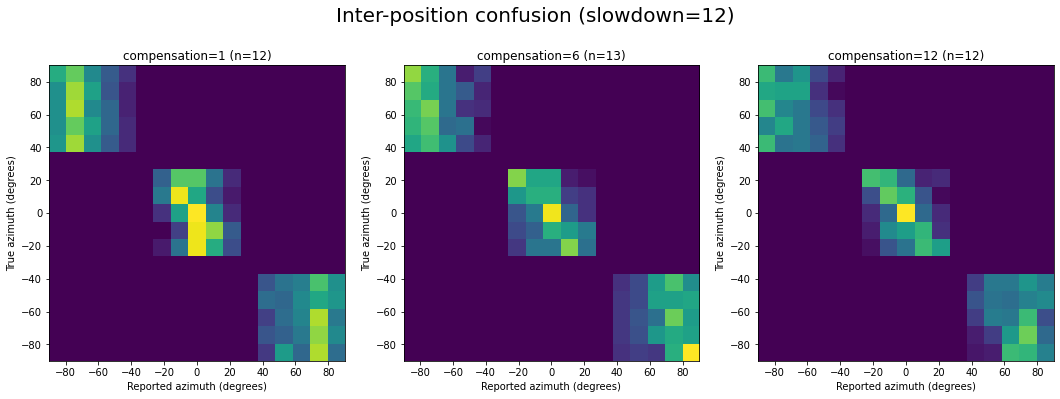

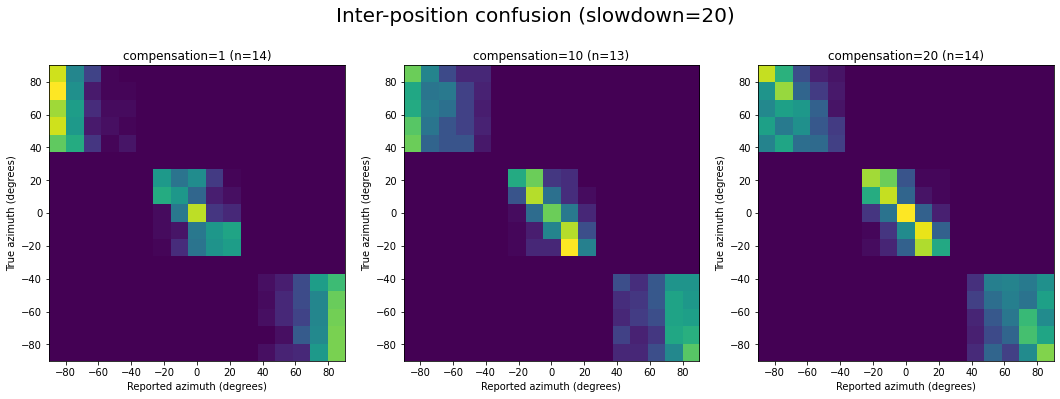

In [3]:

for slowdown in (12, 20):
    conditions = echo_study.subsect(slowdown=slowdown, compensation=[1, slowdown // 2, slowdown])
    plot_confusion(conditions, f"Inter-position confusion (slowdown={slowdown})", ["compensation"])

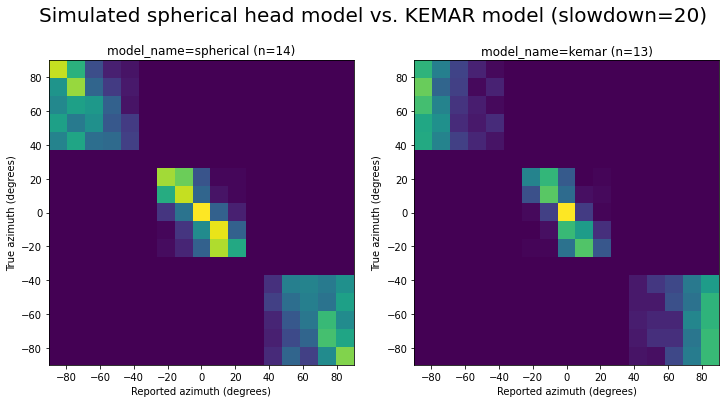

In [4]:
conditions = echo_study.spherical_vs_kemar(compensation=20, slowdown=20)
plot_confusion(conditions, "Simulated spherical head model vs. KEMAR model (slowdown=20)", ["model_name"])


In [5]:
from confusion import ConfusionMatrix
from sensitivity import get_interstim_sensitivities_for_participants, log_fit_sensitivities, lin_fit_sensitivities, multilinear_fit_sensitivities

sectors = ("left", "center", "right",  None)

def plot_sensitivities(conditions, title, get_display_elements):
    
    fig, axes = plt.subplots(nrows=1, ncols=len(sectors), figsize=(20,5), sharey=True)
    fig.suptitle(title, size=20)
    for idx, sector in enumerate(sectors):
        for condition in conditions:
            ax = axes[idx]
            color, marker, linestyle, label = get_display_elements(**condition.values)
            if condition.count() == 0:
                continue
            s = get_interstim_sensitivities_for_participants(condition.get(), sector)
            # xl, yl = multilinear_fit_sensitivities(s)
            x, y = log_fit_sensitivities(s)
            ax.set_title(sector)
            ax.plot(x, y, color=color, label=f"{label} (log)", linestyle=linestyle)
            # ax.plot(xl, yl, color=color, label=f"{label} (lin)", linestyle=linestyle)
            ax.plot(*zip(*s), color=color, marker=marker, linestyle="None")
    plt.xlabel("Inter-stimulus distance (positions)")
    plt.ylabel("Sensitivity index (d')")
    plt.legend(loc="lower right")
    plt.show()



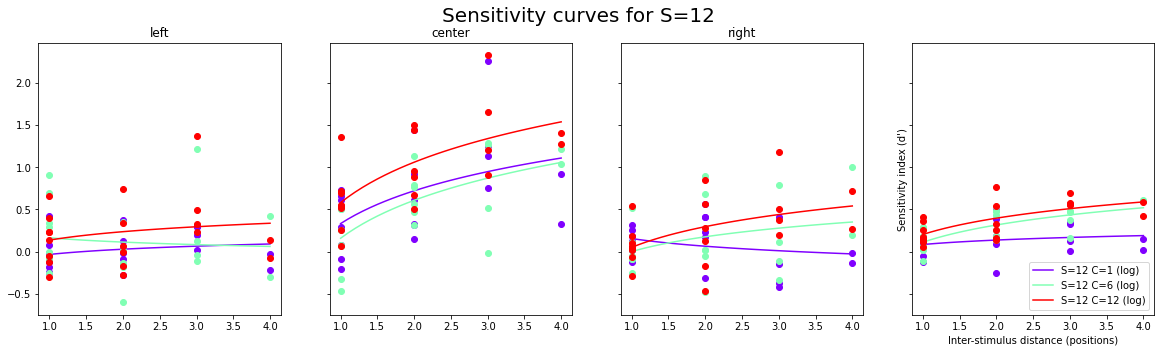

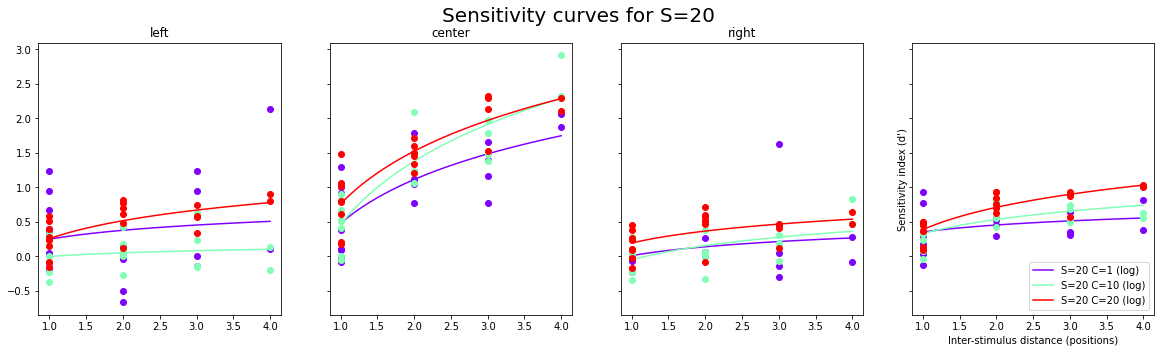

In [6]:
colors = plt.cm.rainbow(np.linspace(0, 1, 3))
compensation_colors = {
    "1": colors[0],
    "half": colors[1],
    "full": colors[2], 
}

def _get_display_elements(slowdown, compensation_descriptor, **rest):
    color = compensation_colors[compensation_descriptor]
    compensation = resolve_compensation_value(slowdown, compensation_descriptor)
    marker = 'o'
    linestyle = '-'
    label = f"S={slowdown} C={compensation}"
    return color, marker, linestyle, label

for slowdown in (12, 20):
    conditions = echo_study.subsect(slowdown=slowdown, compensation_descriptor=["1", "half", "full"])
    plot_sensitivities(conditions, f"Sensitivity curves for S={slowdown}", _get_display_elements)

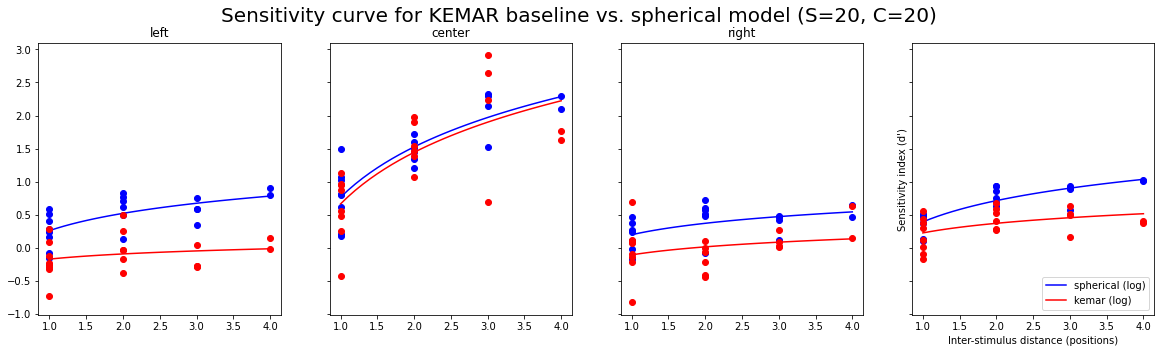

In [7]:
def _get_display_elements(model_name, **rest):
    color = "red" if model_name == "kemar" else "blue"
    marker = "o"
    linestyle = "-"
    label = model_name
    return color, marker, linestyle, label

conditions = echo_study.spherical_vs_kemar(slowdown=20, compensation=20)
plot_sensitivities(conditions, "Sensitivity curve for KEMAR baseline vs. spherical model (S=20, C=20)", _get_display_elements)

In [8]:
from confusion import ConfusionMatrix
from bootstrap import bootstrap_dprime_slope

def plot_bootstrapped_dprime_slope_distributions(conditions, title, label):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,5))
    fig.suptitle(title, size=20)
    bins = np.linspace(-0.4, 1, 100)
    for idx, sector in enumerate(("left", "center", "right")):
        slopes_data = {}
        for condition in conditions:
            hist_ax = axes[0, idx]
            box_ax = axes[1, idx]
            if condition.count() == 0:
                continue
            participants = condition.get()
            label = condition.label(*label)
            confusion_matrices = [ConfusionMatrix.of_indices(p.get_responses(sector=sector)) for p in participants]
            slopes, r2s = bootstrap_dprime_slope(confusion_matrices)
            slopes_data[label] = slopes
            lower = np.percentile(slopes, 0.025)
            upper = np.percentile(slopes, 100 - 0.025)
            # print(f"{label}: 95% confidence interval = {np.round((lower, upper), 2)}")
            hist_ax.set_title(sector)
            hist_ax.hist(slopes, alpha=0.5, bins=bins, label=label)
            # hist_ax.legend(loc='upper right')
        box_ax.boxplot(slopes_data.values())
        box_ax.set_xticklabels(list(slopes_data.keys()), fontdict=None, minor=False)
    plt.show()

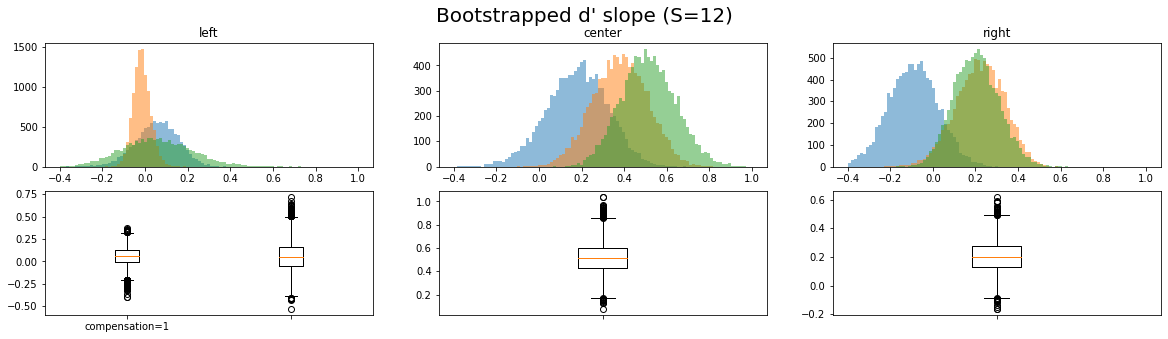

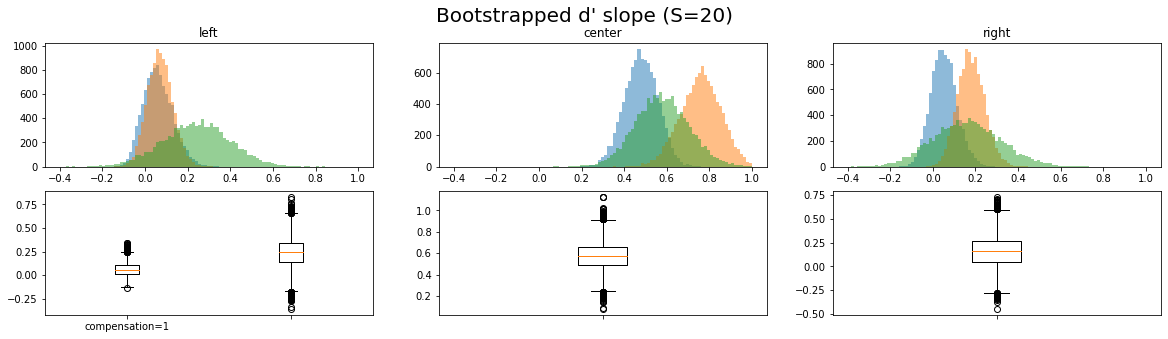

In [9]:
for slowdown in (12, 20):
    compensations = [resolve_compensation_value(slowdown, cv) for cv in ["1", "half", "full"]]
    conditions = echo_study.subsect(slowdown=slowdown, compensation=compensations)
    plot_bootstrapped_dprime_slope_distributions(conditions, f"Bootstrapped d' slope (S={slowdown})", label=["compensation"])

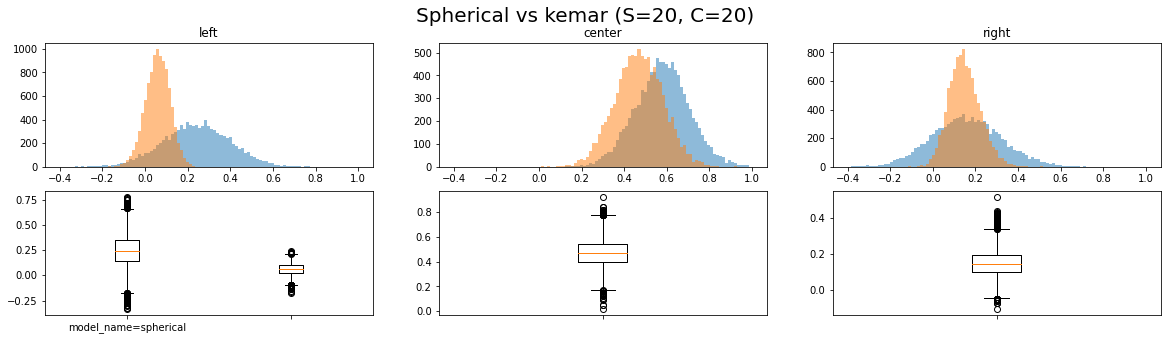

In [10]:
conditions = echo_study.spherical_vs_kemar(slowdown=20, compensation=20)
plot_bootstrapped_dprime_slope_distributions(conditions, "Spherical vs kemar (S=20, C=20)", label=["model_name"])

26 52


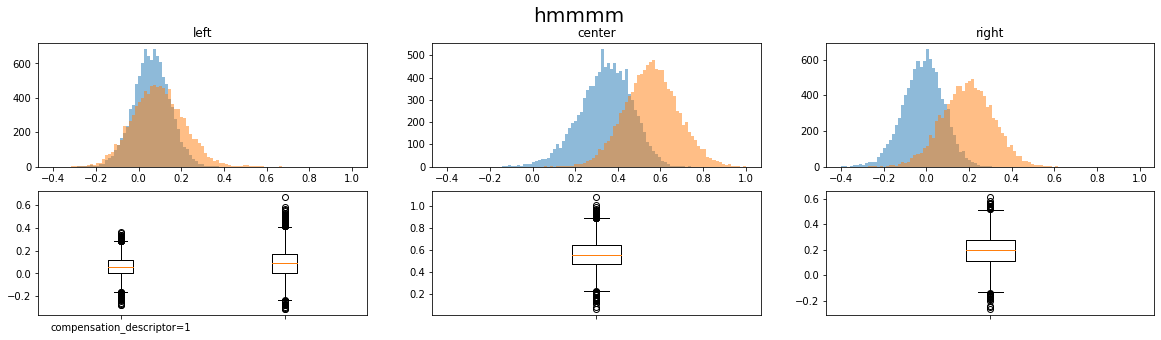

In [11]:
all_uncompensated = echo_study.query_participants(compensation_descriptor="1")
all_compensated = echo_study.query_participants(compensation_descriptor=["half", "full"])
print(all_uncompensated.count(), all_compensated.count())
conditions = [all_uncompensated, all_compensated]
plot_bootstrapped_dprime_slope_distributions(conditions, "hmmmm", label=["compensation_descriptor"])